In [ ]:
# import os
# os.chdir('drive/MyDrive/devcourse/Final/TrainData')
# os.getcwd()

In [ ]:
# !git pull

remote: Enumerating objects: 27, done.
remote: Counting objects: 100% (27/27), done.
remote: Compressing objects: 100% (18/18), done.
remote: Total 24 (delta 8), reused 7 (delta 4), pack-reused 0
Unpacking objects: 100% (24/24), 1.45 MiB | 729.00 KiB/s, done.
From https://github.com/Dev-hoT6/TrainData
   80c563b..31b4939  main       -> origin/main
Updating 80c563b..31b4939
Fast-forward
 final_data/Preprocessed_data/Preprocessed_Onepiece.csv    |  1501 ++
 final_data/Preprocessed_data/Preprocessed_Outer.csv       |  4501 ++++
 final_data/Preprocessed_data/Preprocessed_Pants.csv       |  4498 ++++
 final_data/Preprocessed_data/Preprocessed_Skirt.csv       |  3001 +++
 final_data/Preprocessed_data/Preprocessed_Sport_Outer.csv |  1501 ++
 final_data/Preprocessed_data/Preprocessed_Sport_Pants.csv |   751 +
 final_data/Preprocessed_data/Preprocessed_Sport_Top.csv   |  1499 ++
 final_data/Preprocessed_data/Preprocessed_Top.csv         |  4493 ++++
 final_data/Preprocessed_data/README.md      

# 모델 세팅


## 패키지 설치 및 임포트

In [ ]:
import logging
import numpy as np
import pandas as pd
from tqdm import tqdm

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
# from sentence_transformers.readers import InputExample
# from sentence_transformers import LoggingHandler, losses, models, util, SentenceTransformer
from transformers import AutoTokenizer, AutoModel #, pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

from datetime import datetime
import time
import os
import gc
import math
from tqdm.notebook import tqdm

## working directory 설정

In [ ]:
BASE_DIR_PATH = os.getcwd()
BASE_DIR_PATH = os.path.join(BASE_DIR_PATH, 'drive', 'MyDrive', 'devcourse', 'Final')
DATA_DIR_PATH = os.path.join(BASE_DIR_PATH, 'TrainData', 'final_data')
MODEL_DIR_PATH = os.path.join(BASE_DIR_PATH, 'new_models')
print('proj dir: ', BASE_DIR_PATH)
print('data dir: ', DATA_DIR_PATH)
print('model dir:', MODEL_DIR_PATH)

proj dir:  /content/drive/MyDrive/devcourse/Final
data dir:  /content/drive/MyDrive/devcourse/Final/TrainData/final_data
model dir: /content/drive/MyDrive/devcourse/Final/new_models


## 기타 설정

### 메모리 정리

In [ ]:
# batch size 크기를 줄여가면서 gpu 캐시를 비워주는 코드
gc.collect()
torch.cuda.empty_cache()
# torch.empty_cache()

### logger 초기화

In [ ]:
# logging.basicConfig(
#     format="%(asctime)s - %(message)s",
#     datefmt="%Y-%m-%d %H:%M:%S",
#     level=logging.INFO,
#     handlers=[LoggingHandler()],
# )

### device 선언

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


## 모델 정의

### 모델명 선언

In [ ]:
MODEL_NAME = "snunlp/KR-SBERT-V40K-klueNLI-augSTS"

### 하이퍼파라미터

In [ ]:
PARAMS = {
    'batch_size' : 32,
    'n_epoch' : 50,
    'random_seed' : 778,
    'classifier': {
        'lr' : 0.0001,
        'dropout_rate' : 0.5,
        'weight_decay' : 0.0001,
        'scheduler_gamma' : 0.5,
        'tolerance' : 10,
    }
}

### Base Model path

In [ ]:
# BASE_MODEL_PATH = 'S_Transformer-snunlp_KR-SBERT-V40K-klueNLI-augSTS-BASE.pt'
# BASE_MODEL_PATH = os.path.join(MODEL_DIR_PATH, BASE_MODEL_PATH)
# print(BASE_MODEL_PATH)

### 데이터 가져오기

In [ ]:
DATA_DIR_PATH

'/content/drive/MyDrive/devcourse/Final/TrainData/final_data'

In [ ]:
original = pd.read_csv(os.path.join(DATA_DIR_PATH, 'review_final.csv'))
df = original[['category', 'review', 'score']].loc[original.score != 0]
df.score -= 1
print(len(df))
df.head()

21741


,category,review,score
0,상의,역시 기본 면티는 베이직 하우스죵 ㅎㅎ 학생때부터 즐겨입던 면티입니당!,1.0
1,상의,굉장히 깔끔하고 기본 그 자체!!! 역시 닉값하는 베이직 하우스!! 너무 좋습니다 ㅎㅎ,1.0
2,상의,가격도 싸고 옷감도 부들부들하고 너무 얇지 않아서 좋아요,1.0
3,상의,진짜 잘산거 같아요 무난템…출근복에도 좋아요 160사이즈 딱 좋아요 엉덩이 다 덮어요,1.0
4,상의,남녀공용이라 넉넉하고 두께감은 얇아요 이너로 입기 좋네요,1.0


In [ ]:
df.score.value_counts().sort_index()

0.0     5009
1.0    14699
2.0     2033
Name: score, dtype: int64

In [ ]:
# df = pd.concat([df.loc[df.score == i].sample(2033) for i in range(3)])

In [ ]:
train_data , valid_data = train_test_split(df, train_size=0.6, stratify=df.score, random_state=PARAMS['random_seed'])
valid_data, test_data = train_test_split(valid_data, train_size=0.5, stratify=valid_data.score, random_state=PARAMS['random_seed'])
print(len(train_data), len(valid_data), len(test_data))
print()
print(train_data.score.value_counts().sort_index())
print(valid_data.score.value_counts().sort_index())
print(test_data.score.value_counts().sort_index())

13044 4348 4349

0.0    3005
1.0    8819
2.0    1220
Name: score, dtype: int64
0.0    1002
1.0    2940
2.0     406
Name: score, dtype: int64
0.0    1002
1.0    2940
2.0     407
Name: score, dtype: int64


In [ ]:
# train_data = label_data

train_samples = []
for cat, text, score in train_data.values:
    train_samples.append([(cat, text), int(score)])

print(train_samples[0])
print(len(train_samples))

valid_samples = []
for cat, text, score in valid_data.values:
    valid_samples.append([(cat, text), int(score)])

print(valid_samples[0])
print(len(valid_samples))

test_samples = []
for cat, text, score in test_data.values:
    test_samples.append([(cat, text), int(score)])

print(test_samples[0])
print(len(test_samples))

[('원피스', '좋아요 디자인도 이쁘고 라인도 이뻐서 맘에들어요'), 1]
13044
[('아우터', '일상복으로 입어도될정도로 예뻐요\n데비웨어는 저렴한가격에 예쁜디자인\n넘 좋아요'), 1]
4348
[('원피스', '어반드레스 이 원피스 하나면\n코디 끝입니다!\n몸을 이쁘게 표현해줘요~'), 1]
4349


In [ ]:
train_dataloader = DataLoader(
    train_samples,
    shuffle=True,
    batch_size=PARAMS['batch_size'],
)

valid_dataloader = DataLoader(
    valid_samples,
    shuffle=True,
    batch_size=PARAMS['batch_size'],
)

test_dataloader = DataLoader(
    test_samples,
    shuffle=True,
    batch_size=PARAMS['batch_size'],
)
# train_loss = losses.CosineSimilarityLoss(model=model)

### Load model from HuggingFace Hub

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
embedder = AutoModel.from_pretrained(MODEL_NAME)
# embedder.load_state_dict(torch.load(os.path.join(MODEL_DIR_PATH, 'S_Transformer-snunlp_KR-SBERT-V40K-klueNLI-augSTS-BASE_NEW.pt')))

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/394 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/336k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/967k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/707 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/467M [00:00<?, ?B/s]

In [ ]:
def mean_pooling(model_output, attention_mask):
    token_embeddings = model_output[0] #First element of model_output contains all token embeddings
    input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
    return torch.sum(token_embeddings * input_mask_expanded, 1) / torch.clamp(input_mask_expanded.sum(1), min=1e-9)

In [ ]:
for t in train_dataloader:
    print(t)
    break

[[('하의', '아우터', '아우터', '상의', '하의', '하의', '아우터', '하의', '스커트', '원피스', '상의', '하의', '하의', '하의', '아우터', '상의', '아우터', '하의', '아우터', '스커트', '아우터', '하의', '아우터', '아우터', '하의', '원피스', '아우터', '스커트', '스커트', '스커트', '상의', '하의'), ('두껍고 짱짱해요\n단점은 사이즈표보다 훨씬 더 커요\n같은 브랜드지만 다들 타 공장에서 만들어서 그런지 상품들마다 사이즈가 다 각기각색이네용\n정말 예쁘지만 이녀석은 기장이 정말 길게 나왔네요', '사이즈도 딱이고 일단 세일할때 구매해서 가성비 갑이네요', '가볍고 따뜻하고 활용도가 넘칩니다 구매하세요', '사이즈 딱 오버핏으로 찰떡이에용 휘뚜루마뚜루 갑', '처음에 친구 추천으로 시켜서 입어봤는데 굉장히 만족스럽네요 스타일도 잘 활용 가능하고요사이즈도 괜찮아요 장사이즈로 ㄱㄱ 색이 조금만 덜 진하면 좋을것 같네요', '사이즈도 잘맞고 옷도 예뻐요 세일해서 구매해서 완전 가성비짱', '사기 전에 매장가서 실착해보고 무신사로 시켰는데 역시 예뻐요', '너무 편해용\n핏도 좋구 전투용으로 제격입니다\n다만 사계졀용은 좀 얇아요ㅠ 기모ㄱㄱ하세영', '남찡구도 보고 이쁘다해줫음 ,, 코디가 이리저리 매치하기 쉬운 스커트라 좋고 겨울에도 입을수있고 휘뚜루마뚜루 쌉가능템임 블프세일때 2만원대로 구매해서 개이득봤어요!!', '세일할때 너무 잘산것같아요!!! 밑에 스트링 다양하게 줄여서 포인트줄수있어서 좋아요!!', '입증된 예일인데 말해무엇\n그냥 교복마냥 편하게 입고다녀요', '발목 부분이 생각보다 타이트하네요\n착용감 편하고 운동할때 입어도 좋을 것 같아요.', '사진에서 보이는 그대로 와요! 입기 편하고, 무난해서 다른옷에도 잘어울려요.', '괜찮은 카고팬츠를 세일때 저렴하게 구매해서 만족스러워요.', '다 좋은데 보완점을 말해보자면 !\n맨 아래 부분에 조일 수 있는 끈이 있으면 좋을거 

## Embedding Model 테스트
input:
```python
>>> embedding.encode(['문장1', '문장2', '문장3', ... , '문장 N'])
```
output:  
```
[  
    [벡터1],  
    [벡터2],  
    ...  
    [벡터 N],  
]
```

# 모델 클래스

## Embedding Model

In [ ]:
class EmbeddingModel(nn.Module):
    def __init__(self, tokenizer, embedder, pooler):
        super().__init__()
        self.tokenize = tokenizer
        self.embed = embedder
        self.pool = pooler

    def forward(self, x):
        cat, review = x

        cat_token = self.tokenize(cat, padding=True, truncation=True, return_tensors='pt').to(device)
        rev_token = self.tokenize(review, padding=True, truncation=True, return_tensors='pt').to(device)

        cat_vec = self.embed(**cat_token)
        rev_vec = self.embed(**rev_token)

        cat = self.pool(cat_vec, cat_token['attention_mask'])
        review = self.pool(rev_vec, rev_token['attention_mask'])

        # z = cat + review # [2, 768]
        z = torch.cat([cat, review], 1) # [2, 2 * 768]
        return z

### Classifier

#### 모델 선언

In [ ]:
class ReviewClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc_1 = nn.Linear(768 * 2, 512)
        self.fc_2 = nn.Linear(512, 256)
        self.fc_3 = nn.Linear(256, 3)

        self.relu = nn.ReLU()
        self.leaky = nn.LeakyReLU()
        self.dropout = nn.Dropout(PARAMS['classifier']['dropout_rate'])

    def forward(self, x):
        z = self.leaky(self.fc_1(x))
        z = self.dropout(z)
        z = self.leaky(self.fc_2(z))
        z = self.dropout(z)
        # z = self.leaky(self.fc_2(z))
        # z = self.dropout(z)
        z = self.fc_3(z)
        return z

#### Train Valid 헬퍼 함수

In [ ]:
def train(net, embedder, epoch, optimizer, scheculer, criterion, train_dataloader, device='cuda:0'):
    print('[ Train epoch: %d ]' % epoch)
    net.train() # 모델을 학습 모드로 설정
    train_loss = 0
    correct = 0
    total = 0

    answer = []
    pred = []

    for inputs, targets in tqdm(train_dataloader):
        answer.extend(targets.tolist())

        # print(inputs)
        targets = targets.type(torch.LongTensor).to(device)
        # targets = targets.type(torch.LongTensor).to(device)
        # print(targets)

        optimizer.zero_grad() # 기울기(gradient) 초기화

        vectors = embedder(inputs).detach().to(device)
        outputs = net(vectors) # 모델 입력하여 결과 계산
        # print(outputs)
        # rounded_output = torch.clamp(outputs, 1, 3).round()

        loss = criterion(outputs, targets) # 손실(loss) 값 계산
        # print(loss)
        loss.backward() # 역전파를 통해 기울기(gradient) 계산

        optimizer.step() # 계산된 기울기를 이용해 모델 가중치 업데이트
        train_loss += loss.item()
        _, predicted = outputs.max(1)

        pred.extend(predicted.tolist())

        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
    f1 = f1_score(answer, pred, average='weighted')

    # for i in range(3):
    #     print(pred.count(i))


        # if batch_idx == 0:
        #     print(targets.view(-1))
        #     print(outputs.view(-1))
    scheduler.step()

    print('Train accuracy:{:.6f}'.format(100. * correct / total))
    print('F1-score:{:.6f}'.format(100. * f1))
    print('Train average loss:{:.6f}'.format(train_loss / total))
    return (100. * correct / total, train_loss / total, 100. * f1)


def validate(net, embedder, epoch, criterion, val_dataloader, device='cuda:0'):
    print('[ Validation epoch: %d ]' % epoch)
    net.eval() # 모델을 평가 모드로 설정
    val_loss = 0
    correct = 0
    total = 0

    answer = []
    pred = []

    for inputs, targets in tqdm(val_dataloader):
        answer.extend(targets.tolist())
        # print(answer)

        targets = targets.type(torch.LongTensor).to(device)

        vectors = embedder(inputs).detach().to(device)
        outputs = net(vectors) # 모델 입력하여 결과 계산
        # rounded_output = torch.clamp(outputs, 1, 3).round()

        # pred.extend(outputs.view(-1).tolist())
        # print(pred)

        val_loss += criterion(outputs, targets).item()
        _, predicted = outputs.max(1)
        pred.extend(predicted.tolist())

        # if batch_idx == 0:
        #     print(targets.view(-1))
        #     print(outputs.view(-1))

        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
    f1 = f1_score(answer, pred, average='weighted')

    # for i in range(3):
    #     print(pred.count(i))


    print('Accuracy:{:.6f}'.format(100. * correct / total))
    print('F1-score:{:.6f}'.format(100. * f1))
    print('Average loss:{:.6f}'.format(val_loss / total))
    return (100. * correct / total, val_loss / total, 100. * f1)

#### 학습 진행

In [ ]:
MODEL_SAVE_PATH = os.path.join(os.getcwd(), 'drive', 'MyDrive', 'devcourse', 'Final', 'new_models', 'trained_models')


# batch size 크기를 줄여가면서 gpu 캐시를 비워주는 코드
gc.collect()
torch.cuda.empty_cache()
# torch.empty_cache()

embed_model = EmbeddingModel(tokenizer, embedder, mean_pooling).to(device)
model = ReviewClassifier().to(device)

criterion = torch.nn.functional.cross_entropy
optimizer = torch.optim.Adam(model.parameters(), lr=PARAMS['classifier']['lr'], weight_decay=PARAMS['classifier']['weight_decay'])
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=PARAMS['classifier']['scheduler_gamma'])

train_result = []
val_result = []
val_f1_max = 0
val_loss_min = 999

tolerance = PARAMS['classifier']['tolerance']

start_time = time.time() # 시작 시간
start_timestamp = datetime.utcnow().strftime('%y%m%d_%H%M')
print(start_timestamp)

tol = tolerance
# best_model = ''
for i in tqdm(range(PARAMS['n_epoch'])):
# for i in tqdm(range(5)):

    train_acc, train_loss, train_f1 = train(model, embed_model, i + 1, optimizer, scheduler, criterion, train_dataloader) # 학습(training)
    print()
    val_acc, val_loss, val_f1 = validate(model, embed_model, i + 1, criterion, valid_dataloader) # 검증(validation)

    # 학습된 모델 저장하기
    state = model.state_dict()

    # 디렉토리가 없으면 생성
    if not os.path.isdir(MODEL_SAVE_PATH):
        os.mkdir(MODEL_SAVE_PATH)

    # val_loss가 가장 최솟값일 경우, 모델 저장
    # if val_f1 > val_f1_max:
    if val_loss < val_loss_min or val_f1 > val_f1_max:
        file_name = 'Score_Classifier-{}-{:0>3}-{}.pt'.format(start_timestamp, i + 1, round(val_f1 * 100.))
        torch.save(state, os.path.join(MODEL_SAVE_PATH, file_name))
        print('\nmodel saved!  at {}'.format(os.path.join(MODEL_SAVE_PATH, file_name)))
        # early stopping 횟수 갱신
        tol = tolerance
        # 최솟값/최댓값 갱신
        if val_loss < val_loss_min:
            val_loss_min = val_loss
        if val_f1 > val_f1_max:
            val_f1_max = val_f1
            best_model = file_name

    # val_loss가 최솟값보다 높을 경우, early stopping 횟수 차감
    else:
        tol -= 1
        if tol == 0:
            print(f'\n(time elapsed: {time.time() - start_time:.3f})')
            print('='*40)
            print('Early Stopped!')
            break

    elap_time = int(time.time() - start_time)
    print(f'(time elapsed: {elap_time // 60}분 {elap_time % 60}초)')
    print('='*40)

    # 현재 epoch에서의 정확도(accuracy)와 손실(loss) 값 저장하기
    train_result.append((train_acc, train_loss, train_f1))
    val_result.append((val_acc, val_loss, val_f1))
print('Finished!')
print(f'Best Model Name: {best_model}')
best_model_path = os.path.join(MODEL_SAVE_PATH, 'Architecture-'+file_name)
torch.save(model, best_model_path)

240116_0904


  0%|          | 0/50 [00:00<?, ?it/s]

[ Train epoch: 1 ]


  0%|          | 0/408 [00:00<?, ?it/s]

Train accuracy:72.270776
F1-score:66.948184
Train average loss:0.021267

[ Validation epoch: 1 ]


  0%|          | 0/136 [00:00<?, ?it/s]

Accuracy:74.609016
F1-score:69.178796
Average loss:0.017586

model saved!  at /content/drive/MyDrive/devcourse/Final/new_models/trained_models/Score_Classifier-240116_0904-001-6918.pt
(time elapsed: 1분 35초)
[ Train epoch: 2 ]


  0%|          | 0/408 [00:00<?, ?it/s]

Train accuracy:76.234284
F1-score:73.352919
Train average loss:0.017250

[ Validation epoch: 2 ]


  0%|          | 0/136 [00:00<?, ?it/s]

Accuracy:77.782889
F1-score:75.443369
Average loss:0.015515

model saved!  at /content/drive/MyDrive/devcourse/Final/new_models/trained_models/Score_Classifier-240116_0904-002-7544.pt
(time elapsed: 3분 10초)
[ Train epoch: 3 ]


  0%|          | 0/408 [00:00<?, ?it/s]

Train accuracy:78.396197
F1-score:76.784128
Train average loss:0.015741

[ Validation epoch: 3 ]


  0%|          | 0/136 [00:00<?, ?it/s]

Accuracy:78.909844
F1-score:77.481618
Average loss:0.014835

model saved!  at /content/drive/MyDrive/devcourse/Final/new_models/trained_models/Score_Classifier-240116_0904-003-7748.pt
(time elapsed: 4분 44초)
[ Train epoch: 4 ]


  0%|          | 0/408 [00:00<?, ?it/s]

Train accuracy:78.679853
F1-score:77.443335
Train average loss:0.015164

[ Validation epoch: 4 ]


  0%|          | 0/136 [00:00<?, ?it/s]

Accuracy:79.346826
F1-score:78.218076
Average loss:0.014520

model saved!  at /content/drive/MyDrive/devcourse/Final/new_models/trained_models/Score_Classifier-240116_0904-004-7822.pt
(time elapsed: 6분 19초)
[ Train epoch: 5 ]


  0%|          | 0/408 [00:00<?, ?it/s]

Train accuracy:79.331493
F1-score:78.200049
Train average loss:0.014959

[ Validation epoch: 5 ]


  0%|          | 0/136 [00:00<?, ?it/s]

Accuracy:79.507820
F1-score:78.376262
Average loss:0.014401

model saved!  at /content/drive/MyDrive/devcourse/Final/new_models/trained_models/Score_Classifier-240116_0904-005-7838.pt
(time elapsed: 7분 54초)
[ Train epoch: 6 ]


  0%|          | 0/408 [00:00<?, ?it/s]

Train accuracy:79.132168
F1-score:78.039391
Train average loss:0.014773

[ Validation epoch: 6 ]


  0%|          | 0/136 [00:00<?, ?it/s]

Accuracy:79.553818
F1-score:78.535200
Average loss:0.014322

model saved!  at /content/drive/MyDrive/devcourse/Final/new_models/trained_models/Score_Classifier-240116_0904-006-7854.pt
(time elapsed: 9분 28초)
[ Train epoch: 7 ]


  0%|          | 0/408 [00:00<?, ?it/s]

Train accuracy:79.714811
F1-score:78.734672
Train average loss:0.014669

[ Validation epoch: 7 ]


  0%|          | 0/136 [00:00<?, ?it/s]

Accuracy:79.645814
F1-score:78.647436
Average loss:0.014299

model saved!  at /content/drive/MyDrive/devcourse/Final/new_models/trained_models/Score_Classifier-240116_0904-007-7865.pt
(time elapsed: 11분 3초)
[ Train epoch: 8 ]


  0%|          | 0/408 [00:00<?, ?it/s]

Train accuracy:79.323827
F1-score:78.355677
Train average loss:0.014793

[ Validation epoch: 8 ]


  0%|          | 0/136 [00:00<?, ?it/s]

Accuracy:79.829807
F1-score:78.838425
Average loss:0.014292

model saved!  at /content/drive/MyDrive/devcourse/Final/new_models/trained_models/Score_Classifier-240116_0904-008-7884.pt
(time elapsed: 12분 38초)
[ Train epoch: 9 ]


  0%|          | 0/408 [00:00<?, ?it/s]

Train accuracy:79.921803
F1-score:78.991538
Train average loss:0.014649

[ Validation epoch: 9 ]


  0%|          | 0/136 [00:00<?, ?it/s]

Accuracy:79.760810
F1-score:78.765227
Average loss:0.014289

model saved!  at /content/drive/MyDrive/devcourse/Final/new_models/trained_models/Score_Classifier-240116_0904-009-7877.pt
(time elapsed: 14분 13초)
[ Train epoch: 10 ]


  0%|          | 0/408 [00:00<?, ?it/s]

Train accuracy:79.599816
F1-score:78.595197
Train average loss:0.014616

[ Validation epoch: 10 ]


  0%|          | 0/136 [00:00<?, ?it/s]

Accuracy:79.783809
F1-score:78.785954
Average loss:0.014280

model saved!  at /content/drive/MyDrive/devcourse/Final/new_models/trained_models/Score_Classifier-240116_0904-010-7879.pt
(time elapsed: 15분 45초)
[ Train epoch: 11 ]


  0%|          | 0/408 [00:00<?, ?it/s]

Train accuracy:80.105796
F1-score:79.105492
Train average loss:0.014651

[ Validation epoch: 11 ]


  0%|          | 0/136 [00:00<?, ?it/s]

Accuracy:79.806808
F1-score:78.815214
Average loss:0.014278

model saved!  at /content/drive/MyDrive/devcourse/Final/new_models/trained_models/Score_Classifier-240116_0904-011-7882.pt
(time elapsed: 17분 19초)
[ Train epoch: 12 ]


  0%|          | 0/408 [00:00<?, ?it/s]

Train accuracy:79.316161
F1-score:78.310638
Train average loss:0.014852

[ Validation epoch: 12 ]


  0%|          | 0/136 [00:00<?, ?it/s]

Accuracy:79.806808
F1-score:78.815214
Average loss:0.014272

model saved!  at /content/drive/MyDrive/devcourse/Final/new_models/trained_models/Score_Classifier-240116_0904-012-7882.pt
(time elapsed: 18분 53초)
[ Train epoch: 13 ]


  0%|          | 0/408 [00:00<?, ?it/s]

Train accuracy:79.262496
F1-score:78.317448
Train average loss:0.014719

[ Validation epoch: 13 ]


  0%|          | 0/136 [00:00<?, ?it/s]

Accuracy:79.783809
F1-score:78.794486
Average loss:0.014277
(time elapsed: 20분 26초)
[ Train epoch: 14 ]


  0%|          | 0/408 [00:00<?, ?it/s]

Train accuracy:79.584483
F1-score:78.620112
Train average loss:0.014694

[ Validation epoch: 14 ]


  0%|          | 0/136 [00:00<?, ?it/s]

Accuracy:79.760810
F1-score:78.773764
Average loss:0.014280
(time elapsed: 21분 59초)
[ Train epoch: 15 ]


  0%|          | 0/408 [00:00<?, ?it/s]

Train accuracy:79.461822
F1-score:78.446846
Train average loss:0.014775

[ Validation epoch: 15 ]


  0%|          | 0/136 [00:00<?, ?it/s]

Accuracy:79.760810
F1-score:78.773764
Average loss:0.014280
(time elapsed: 23분 32초)
[ Train epoch: 16 ]


  0%|          | 0/408 [00:00<?, ?it/s]

Train accuracy:79.630481
F1-score:78.696782
Train average loss:0.014722

[ Validation epoch: 16 ]


  0%|          | 0/136 [00:00<?, ?it/s]

Accuracy:79.760810
F1-score:78.773764
Average loss:0.014273
(time elapsed: 25분 6초)
[ Train epoch: 17 ]


  0%|          | 0/408 [00:00<?, ?it/s]

Train accuracy:79.622815
F1-score:78.633651
Train average loss:0.014767

[ Validation epoch: 17 ]


  0%|          | 0/136 [00:00<?, ?it/s]

Accuracy:79.760810
F1-score:78.773764
Average loss:0.014273
(time elapsed: 26분 40초)
[ Train epoch: 18 ]


  0%|          | 0/408 [00:00<?, ?it/s]

Train accuracy:79.860472
F1-score:78.947554
Train average loss:0.014662

[ Validation epoch: 18 ]


  0%|          | 0/136 [00:00<?, ?it/s]

Accuracy:79.760810
F1-score:78.773764
Average loss:0.014276
(time elapsed: 28분 14초)
[ Train epoch: 19 ]


  0%|          | 0/408 [00:00<?, ?it/s]

Train accuracy:79.653481
F1-score:78.695279
Train average loss:0.014694

[ Validation epoch: 19 ]


  0%|          | 0/136 [00:00<?, ?it/s]

Accuracy:79.760810
F1-score:78.773764
Average loss:0.014285
(time elapsed: 29분 47초)
[ Train epoch: 20 ]


  0%|          | 0/408 [00:00<?, ?it/s]

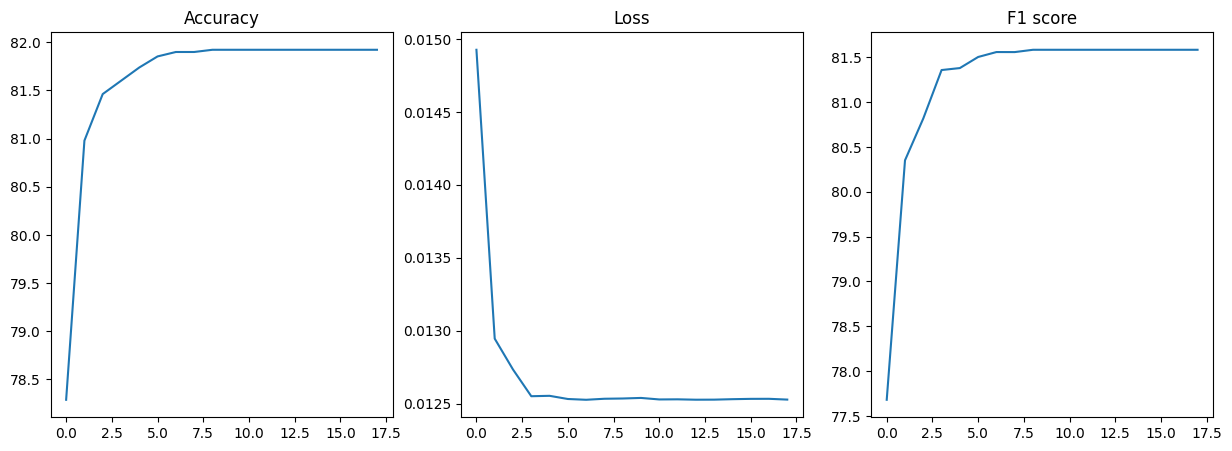

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(15, 5))

plt.subplot(131)
plt.plot(list(zip(*val_result))[0])
plt.title('Accuracy')

plt.subplot(132)
plt.plot(list(zip(*val_result))[1])
plt.title('Loss')

plt.subplot(133)
plt.plot(list(zip(*val_result))[2])
plt.title('F1 score')

plt.show()

#### 모델 테스트

In [ ]:
MODEL_DIR_PATH

'/content/drive/MyDrive/devcourse/Final/new_models'

In [ ]:
criterion = torch.nn.functional.cross_entropy

embed_model = EmbeddingModel(tokenizer, embedder, mean_pooling).to(device)
model = torch.load(best_model_path)
validate(model, embed_model, 1, criterion, test_dataloader)

[ Validation epoch: 1 ]


  0%|          | 0/136 [00:00<?, ?it/s]

Accuracy:83.582433
F1-score:83.282926
Average loss:0.011830


(83.58243274315934, 0.011829796218274517, 83.28292561938939)